In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf

In [2]:
def my_quant(x, Q):
    r"""Saturated uniform midtread quantizer

    input:
    x  input signal
    Q  number of quantization steps
    output:
    xq quantized signal

    Note: for even Q in order to retain midtread characteristics,
    we must omit one quantization step, either that for lowest or the highest
    amplitudes. Typically the highest signal amplitudes are saturated to
    the 'last' quantization step. Then, in the special case of log2(N)
    being an integer the quantization can be represented with bits.
    """
    tmp = Q//2  

    xq = np.round(x*tmp) / tmp

    xq[xq < -1.] = -1.
    
    tmp2 = ((Q-1) - tmp) / tmp  
    xq[xq > tmp2] = tmp2
    return xq

In [3]:
def my_xcorr2(x, y, scaleopt='none'):
    r""" Cross Correlation function phixy[kappa] -> x[k+kappa] y

    input:
    x   input signal shifted by +kappa
    y   input signal
    scaleopt   scaling of CCF estimator
    output:
    kappa   sample index
    ccf   correlation result
    """
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

In [4]:
def check_my_quant(Q):
    N = int(5e2)
    x = 2 * np.arange(N) / N - 1
    xq = my_quant(x, Q)
    e = xq - x

    plt.plot(x, x, color='C2', lw=3, label=r'$x[k]$')
    plt.plot(x, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(x, e, color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.xticks(np.arange(-1, 1.25, 0.25))
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.xlabel('input amplitude')
    plt.ylabel('output amplitude')
    if Q % 2 == 0:
        s = ' saturated '
    else:
        s = ' '
    plt.title(
        r'uniform' + s + r'midtread quantization with Q=%d steps, $\Delta Q$=%4.3e' % (Q, 1/(Q//2))
    )
    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.grid(True)


In [5]:
fs = 3000
N = 2 * fs
k = np.arange(0, N)
fsin = 400

def check_dithering(x,dither,Q,case):
    deltaQ=1/(Q//2)
   
    pdf_dither, edges_dither=np.histogram(dither,bins='auto', density=True)
    xd=x+dither
   
    xq=my_quant(xd,Q)
    e=xq-x
    pdf_error,edges_error=np.histogram(e,bins='auto', density=True)
  
    sf.write(file=f'x_{case}.wav', data=x, samplerate=3000, subtype='PCM_24')
    sf.write(file=f'xd_{case}.wav', data=xd, samplerate=3000, subtype='PCM_24')
    sf.write(file=f'xq_{case}.wav', data=xq, samplerate=3000, subtype='PCM_24')
    sf.write(file=f'e_{case}.wav', data=e, samplerate=3000, subtype='PCM_24')
    
    kappa, ccf = my_xcorr2(xq, e, scaleopt='biased')
    plt.figure(figsize=(12, 3))
    if case == 'nodither':
        plt.subplot(1, 2, 1)
      
    else:
       
        plt.subplot(1,2,1)
        plt.plot(edges_dither[:-1],pdf_dither,'o-',ms=5)
        plt.ylim(-0.1,np.max(pdf_dither)*1.1)
        plt.grid(True)
        plt.xlabel(r'$\theta$')
        plt.ylabel(r'$\hat{p}(\theta)$')
        plt.title('PDF estimate of dither noise')

    plt.subplot(1,2,2)
    plt.plot(edges_error[:-1],pdf_error,'o-',ms=5)
    plt.ylim(-0.1,np.max(pdf_error)*1.1)
    plt.grid(True)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\hat{p}(\theta)$')
    plt.title('PDF estimate of error noise')


    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(k, x, color='C2', label=r'$x[k]$')
    plt.plot(k, xd, color='C1', label=r'$x_d[k]=x[k]+dither[k]$')
    plt.plot(k, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(k, e, color='C0', label=r'$e[k]=x_q[k]-x[k]$')
    plt.plot(k, k * 0 + deltaQ, ':k', label=r'$\Delta Q$')
    plt.xlabel('k')
    plt.title('Signal')
    plt.xticks(np.arange(0, 175, 25))
    plt.xlim(0, 150)
    plt.legend(loc='lower left')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(kappa, ccf)
    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'$\varphi_{xq,e}[\kappa]$')
    plt.title('CCF between $x_q$ and $e = x_q - x$')
    plt.xticks(np.arange(-100, 125, 25))
    plt.xlim(-100, 100)
    plt.grid(True)





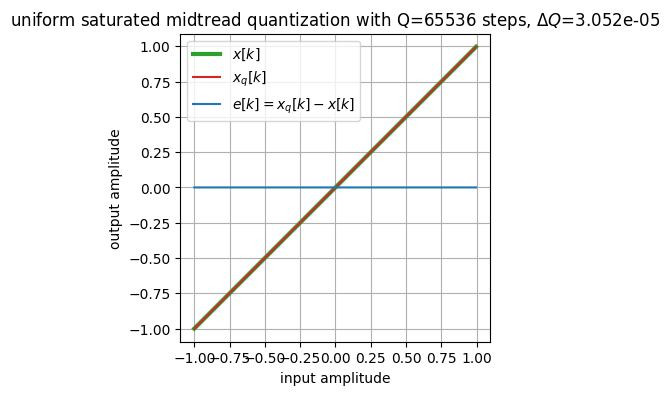

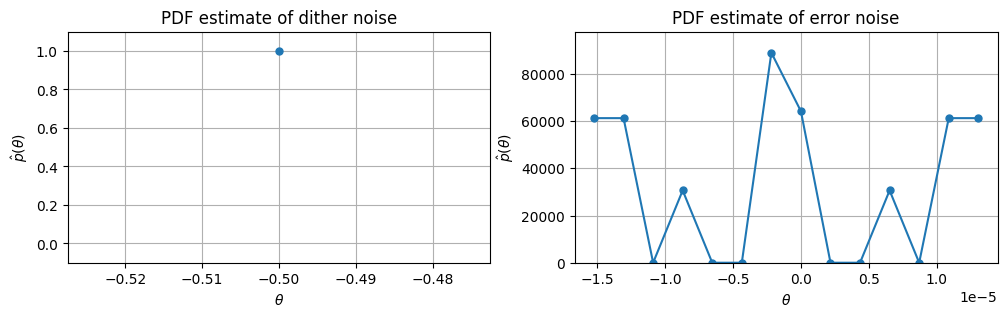

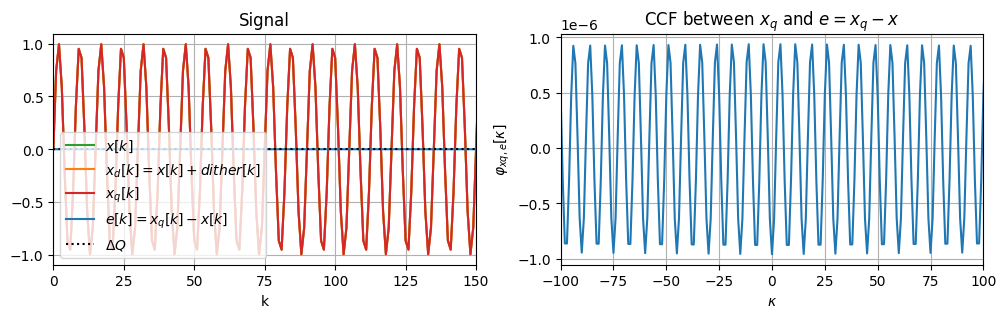

In [6]:
B = 16  
Q = 2**B  
deltaQ = 1 / (Q // 2)  
x = (1 - deltaQ) * np.sin(2 * np.pi * fsin / fs * k)  
plt.figure(figsize=(4, 4))
check_my_quant (Q)

check_dithering(x=x, dither=x * 0, Q=Q, case='case 1')

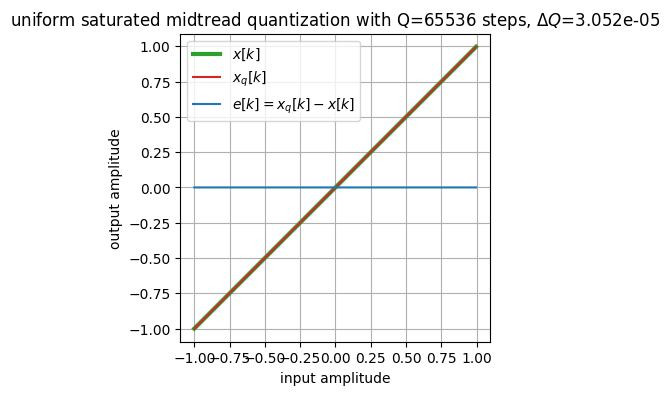

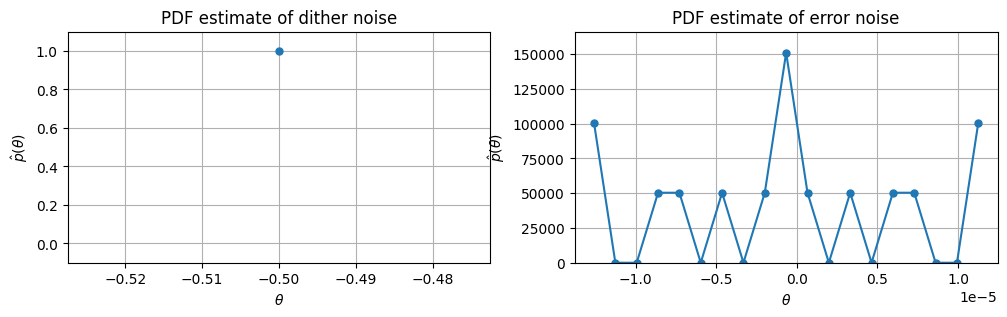

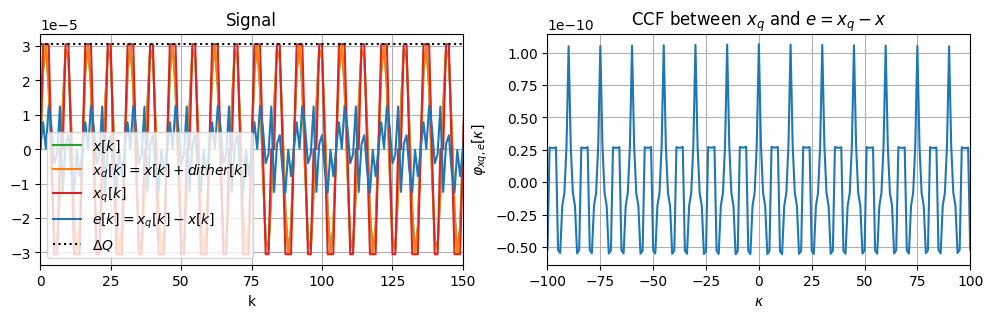

In [7]:
# case 2
B = 16
Q = 2**B
deltaQ = 1 / (Q // 2)
x = deltaQ * np.sin(2 * np.pi * fsin / fs * k)  
plt.figure(figsize=(4, 4))
check_my_quant (Q)
check_dithering(x=x, dither=x * 0, Q=Q, case='case 2')

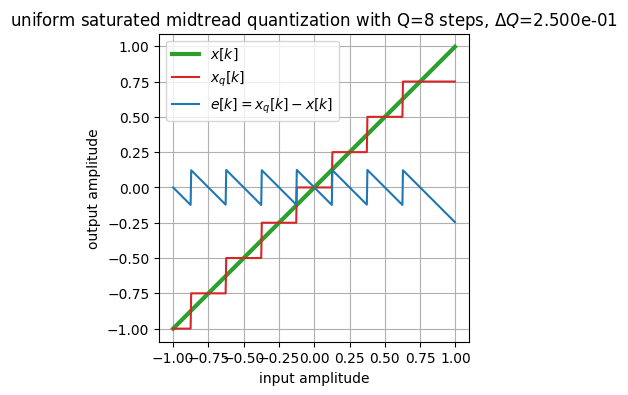

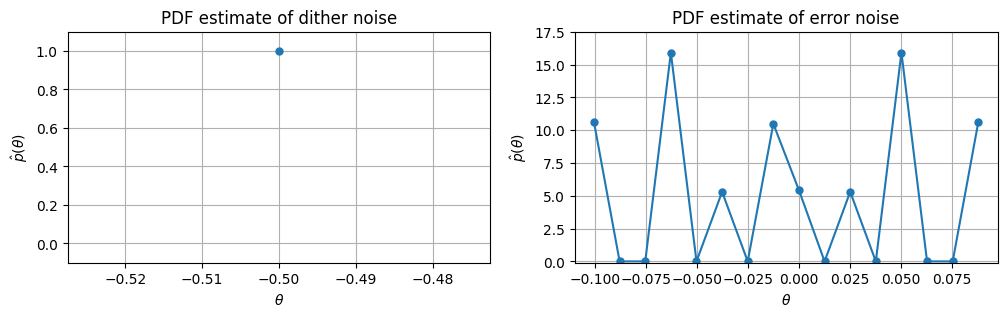

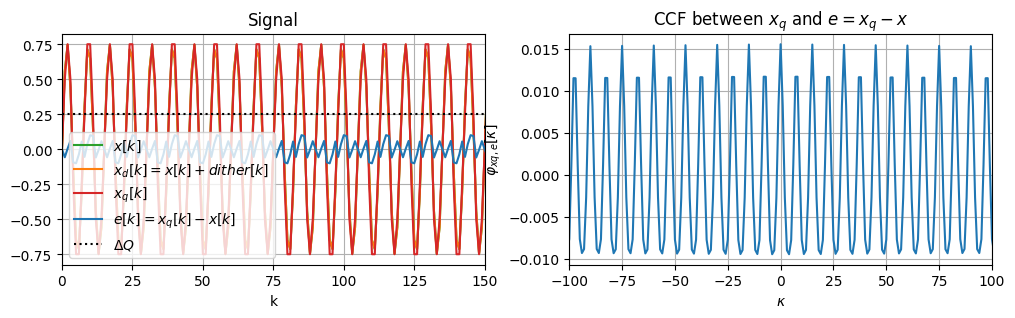

In [8]:

# case 3
B = 3
Q = 2**B
deltaQ = 1 / (Q // 2)
x = (1 - deltaQ) * np.sin(2 * np.pi * fsin / fs * k)
plt.figure(figsize=(4, 4))
check_my_quant (Q)
check_dithering(x=x, dither=x * 0, Q=Q, case='case 3')

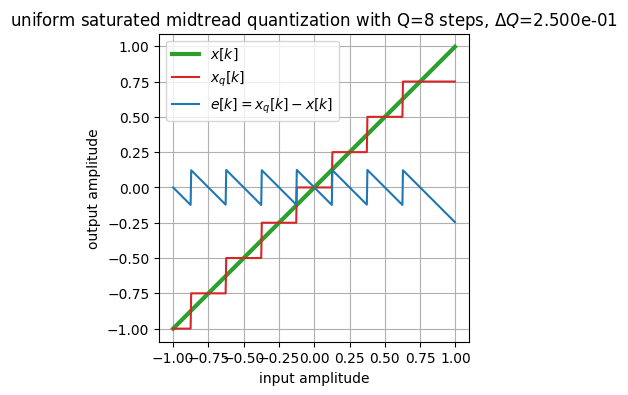

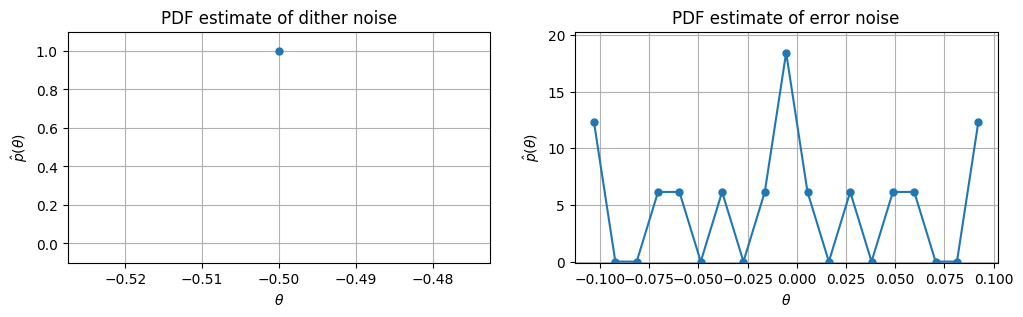

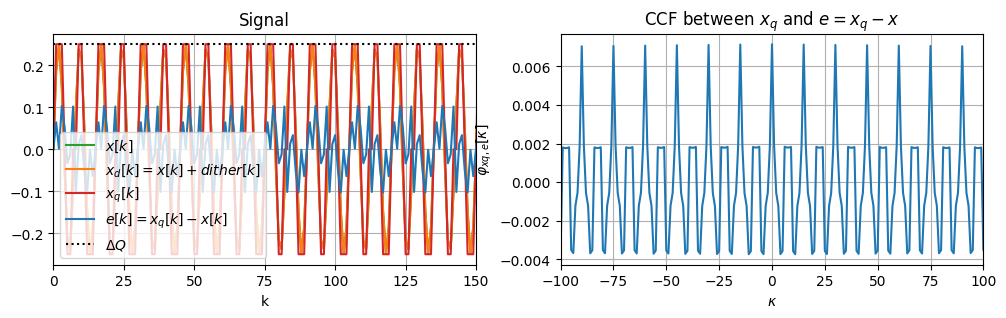

In [9]:
# case 4
B = 3
Q = 2**B
deltaQ = 1 / (Q // 2)
x = deltaQ * np.sin(2 * np.pi * fsin / fs * k)
plt.figure(figsize=(4, 4))
check_my_quant (Q)

check_dithering(x=x, dither=x * 0, Q=Q, case='case 4')

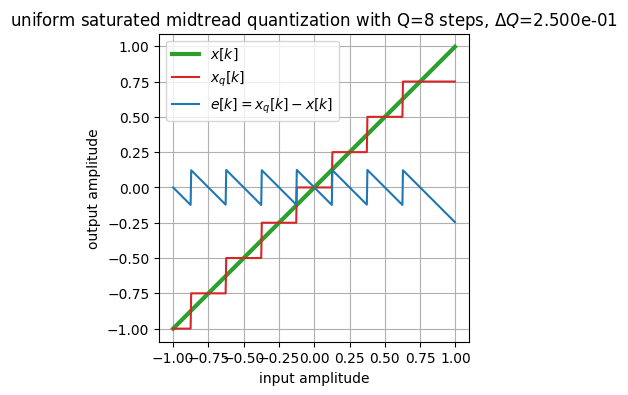

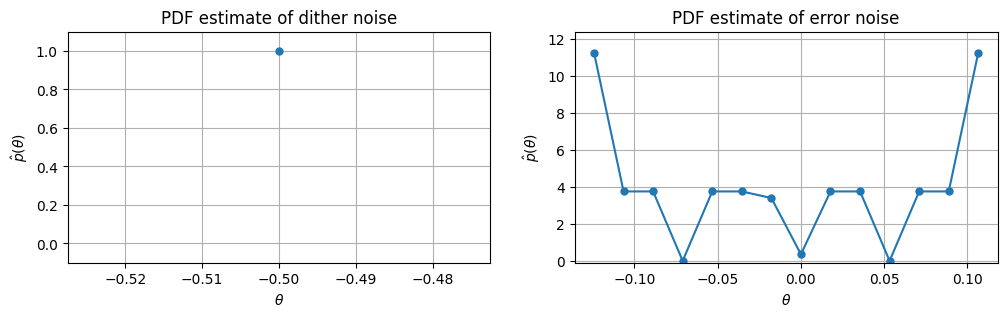

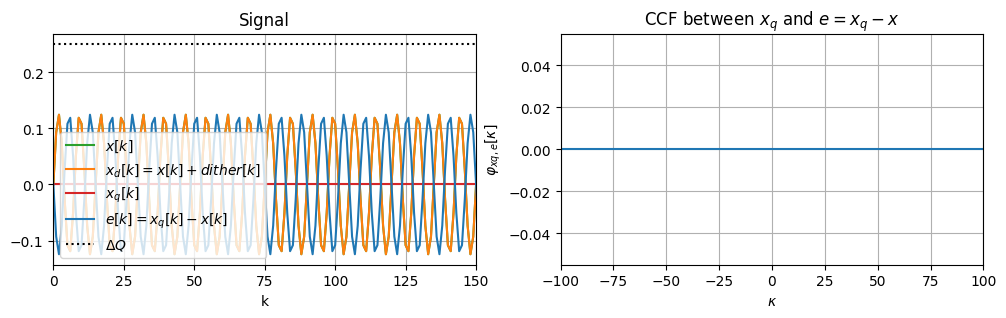

In [10]:
# case 5

B = 3
Q = 2**B
deltaQ = 1 / (Q // 2)

x = deltaQ / 2 * np.sin(2 * np.pi * fsin / fs * k)

plt.figure(figsize=(4, 4))
check_my_quant (Q)

check_dithering(x=x, dither=x * 0, Q=Q, case='case 5')